# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

device = torch.device("cuda:0") # Let's make sure GPU is available!

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                                std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', download=True,
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
#plt.imshow(data_train.__getitem__(5)[0].permute(1, 2, 0))  

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [0]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [0]:
def display_history(loss_history, train_history, val_history):
    plt.figure(figsize=(14, 5))
    plt.subplot('121')
    plt.title("Train/Validation accuracy")
    plt.plot(train_history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.subplot('122')
    plt.title("Loss")
    plt.plot(loss_history, label='loss')
    plt.legend();

In [0]:
model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )
model.type(torch.cuda.FloatTensor)
model.to(device) 
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [0]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % 
              (epoch+1, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: torch doesn't have a dedicated argmax function,
    #       but you can use torch.max instead (see the documentation).
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)    
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    return float(correct_samples) / total_samples

In [114]:
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 20)

Epoch: 1, Average loss: 1.820135, Train accuracy: 0.416715, Val accuracy: 0.556276
Epoch: 2, Average loss: 1.446078, Train accuracy: 0.588728, Val accuracy: 0.604191
Epoch: 3, Average loss: 1.373786, Train accuracy: 0.622888, Val accuracy: 0.629309
Epoch: 4, Average loss: 1.348834, Train accuracy: 0.635771, Val accuracy: 0.633882
Epoch: 5, Average loss: 1.335089, Train accuracy: 0.640395, Val accuracy: 0.643574
Epoch: 6, Average loss: 1.325517, Train accuracy: 0.648790, Val accuracy: 0.651218
Epoch: 7, Average loss: 1.321073, Train accuracy: 0.648603, Val accuracy: 0.650126
Epoch: 8, Average loss: 1.317850, Train accuracy: 0.651333, Val accuracy: 0.654836
Epoch: 9, Average loss: 1.315820, Train accuracy: 0.649729, Val accuracy: 0.650945
Epoch: 10, Average loss: 1.314900, Train accuracy: 0.653175, Val accuracy: 0.630196
Epoch: 11, Average loss: 1.311873, Train accuracy: 0.652988, Val accuracy: 0.645007
Epoch: 12, Average loss: 1.310969, Train accuracy: 0.654131, Val accuracy: 0.656269
E

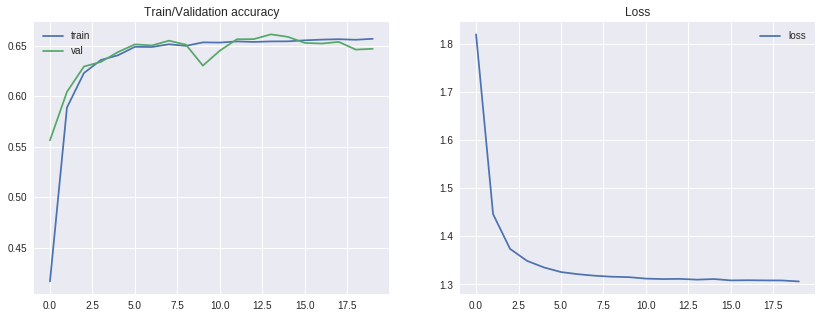

In [116]:
display_history(loss_history, train_history, val_history)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [0]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
       )
model.type(torch.cuda.FloatTensor)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 20)

Добавьте слой с Batch Normalization

In [0]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
         )
model.type(torch.cuda.FloatTensor)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 20)

Добавьте уменьшение скорости обучения по ходу тренировки.

In [0]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
         )
model.type(torch.cuda.FloatTensor)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: .98**((epoch+1) // 2))
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, 
                                                       loss, optimizer, 20, scheduler)

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [0]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    #raise Exception("Not implemented")
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    predictions = []
    ground_truth = []
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)    
        _, ind = torch.max(prediction, 1)
        predictions += list(ind.cpu().data.numpy())
        ground_truth += list(y.data.numpy())
    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

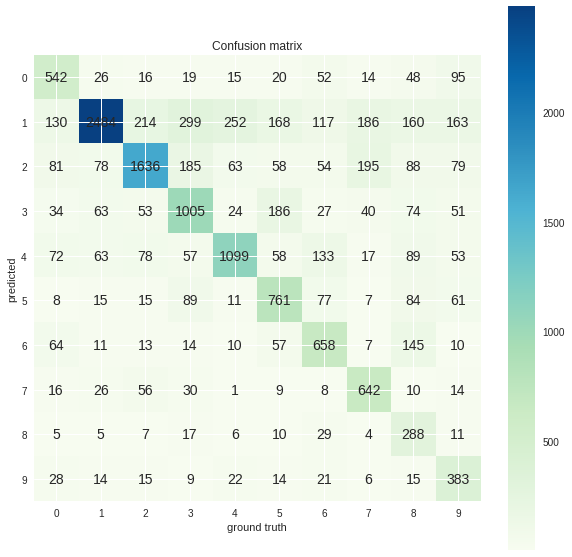

In [120]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    data = np.vstack((predictions, ground_truth)).T
    for i in range(10):
        for j in range(10):
            confusion_matrix[i][j] = len(data[(data[:, 0] == i) & (data[:, 1] == j)])
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

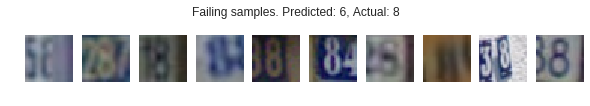

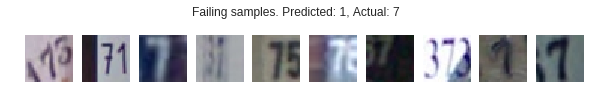

In [121]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, val_data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    #raise Exception("Not implemented")
    data = np.vstack((val_indices, predictions, ground_truth)).T
    indices = data[(data[:, 1] == predicted_class) & (data[:, 2] == gt_class)][:,0]
    title = f'Failing samples. Predicted: {predicted_class}, Actual: {gt_class}'
    visualize_images(indices, val_data, title=title, max_num=10)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [181]:
# Experiment here!
#Best: Epoch: 2, Average loss: 0.273843, Train accuracy: 0.921066, Val accuracy: 0.869702 (pretrained)
model = nn.Sequential(
    Flattener(),
    #---
    nn.Linear(3*32*32, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(inplace=True),
    #---
    nn.Linear(200, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(inplace=True),
    #---
    nn.Linear(200, 10),
         )
model.type(torch.cuda.FloatTensor)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2.5e-4, weight_decay=2e-4)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: .985**((epoch+1) // 2))
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, 
                                                       loss, optimizer, 20, scheduler)
#Epoch: 1, Average loss: 1.422093, Train accuracy: 0.554073, Val accuracy: 0.707802
#Epoch: 5, Average loss: 0.661490, Train accuracy: 0.793025, Val accuracy: 0.800833
#Epoch: 10, Average loss: 0.524439, Train accuracy: 0.835324, Val accuracy: 0.834278
#Epoch: 15, Average loss: 0.462645, Train accuracy: 0.854622, Val accuracy: 0.845744
#Epoch: 20, Average loss: 0.412639, Train accuracy: 0.869245, Val accuracy: 0.847997

Epoch: 1, Average loss: 1.396379, Train accuracy: 0.567382, Val accuracy: 0.702751
Epoch: 2, Average loss: 0.923169, Train accuracy: 0.713016, Val accuracy: 0.737015
Epoch: 3, Average loss: 0.785341, Train accuracy: 0.755554, Val accuracy: 0.778036
Epoch: 4, Average loss: 0.710075, Train accuracy: 0.779135, Val accuracy: 0.781244
Epoch: 5, Average loss: 0.658568, Train accuracy: 0.794509, Val accuracy: 0.813733
Epoch: 6, Average loss: 0.624697, Train accuracy: 0.805856, Val accuracy: 0.818374
Epoch: 7, Average loss: 0.599260, Train accuracy: 0.811521, Val accuracy: 0.816668
Epoch: 8, Average loss: 0.572244, Train accuracy: 0.820394, Val accuracy: 0.832571
Epoch: 9, Average loss: 0.553122, Train accuracy: 0.826281, Val accuracy: 0.817555
Epoch: 10, Average loss: 0.535268, Train accuracy: 0.832065, Val accuracy: 0.814893
Epoch: 11, Average loss: 0.520041, Train accuracy: 0.837747, Val accuracy: 0.834755
Epoch: 12, Average loss: 0.502488, Train accuracy: 0.842371, Val accuracy: 0.823357
E

In [182]:
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=4e-4)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 1, Average loss: 0.354371, Train accuracy: 0.891359, Val accuracy: 0.863081
Epoch: 2, Average loss: 0.337419, Train accuracy: 0.895881, Val accuracy: 0.861443
Epoch: 3, Average loss: 0.334482, Train accuracy: 0.897092, Val accuracy: 0.862262


In [184]:
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=8e-4)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 1, Average loss: 0.315068, Train accuracy: 0.903474, Val accuracy: 0.864651
Epoch: 2, Average loss: 0.312932, Train accuracy: 0.905027, Val accuracy: 0.865470
Epoch: 3, Average loss: 0.309584, Train accuracy: 0.905573, Val accuracy: 0.864719


In [186]:
optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=1.6e-3)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 1, Average loss: 0.304667, Train accuracy: 0.907774, Val accuracy: 0.865333
Epoch: 2, Average loss: 0.304877, Train accuracy: 0.905897, Val accuracy: 0.864310
Epoch: 3, Average loss: 0.305373, Train accuracy: 0.907313, Val accuracy: 0.865470


In [189]:
optimizer = optim.Adam(model.parameters(), lr=.5e-6, weight_decay=1.6e-3)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 1, Average loss: 0.301315, Train accuracy: 0.909122, Val accuracy: 0.865470
Epoch: 2, Average loss: 0.302911, Train accuracy: 0.907928, Val accuracy: 0.864992
Epoch: 3, Average loss: 0.304722, Train accuracy: 0.906955, Val accuracy: 0.866289


In [190]:
# Как всегда, в конце проверяем на test set
#Best: 8503
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8503


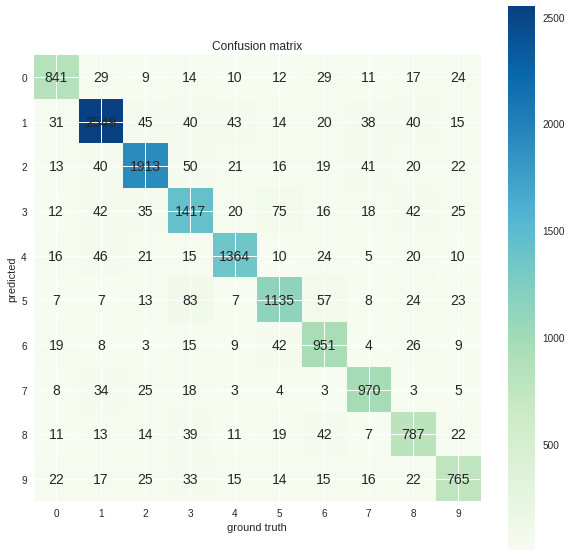

In [191]:
predictions, gt = evaluate_model(model, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

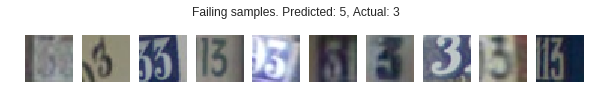

In [195]:
visualize_predicted_actual(5, 3, predictions, gt, np.array(val_indices), data_train_images)